In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Caricamento dataset

In [2]:
conllu_dir = 'FB_profilingUD_annotazione_linguistica' # cartella con i file .conllu, con l'annotazione linguistica

## Divisione in training e test set

In [3]:
train_files = []
test_files = []

for file_name in os.listdir(conllu_dir):
    file_path = os.path.join(conllu_dir, file_name)
    if 'train' in file_name:
        train_files.append(file_path)
    elif 'test' in file_name:
        test_files.append(file_path)

print('Documenti training set:', len(train_files))
print('Documenti test set:', len(test_files))

Documenti training set: 3000
Documenti test set: 1000


## Lettura dei file .conllu

In [4]:
def get_sentences_from_file(src_path):
    file_sentences = [] # lista che conterrà tutte le frasi del file
    sentence = []
    for line in open(src_path, 'r'): # scorro il file riga per riga
        if line[0].isdigit(): # se la riga inizia con un numero, cioè non siamo nell'intestazione del file
            splitted_line = line.strip().split('\t')
            if '-' not in splitted_line[0]:  # se l'id della parola non contiene un trattino (= no prep. articolata)
                token = {'word': splitted_line[1], 'lemma': splitted_line[2], 'pos': splitted_line[3]}
                sentence.append(token)
        if line == '\n':  # se la riga è vuota significa che la frase è finita
            file_sentences.append(sentence) # inserisco la frase nella lista di frasi di quel file
            sentence = []
    return file_sentences

In [5]:
train_dataset = []
y_train = []
for file_path in train_files: # per ogni documento di training
    file_sentences = get_sentences_from_file(file_path) # prendo le frasi di quel documento
    train_dataset.append(file_sentences)
    y_train.append(int(file_path.split('-')[2]))

In [6]:
train_dataset[1][1] # esempio, seconda frase del secondo file di training

[{'word': 'Poverini', 'lemma': 'Poverini', 'pos': 'NOUN'},
 {'word': 'dopo', 'lemma': 'dopo', 'pos': 'ADP'},
 {'word': 'tutte', 'lemma': 'tutto', 'pos': 'DET'},
 {'word': 'le', 'lemma': 'il', 'pos': 'DET'},
 {'word': 'miniere', 'lemma': 'miniera', 'pos': 'NOUN'},
 {'word': 'scavate', 'lemma': 'scavato', 'pos': 'ADJ'},
 {'word': 'ci', 'lemma': 'ci', 'pos': 'PRON'},
 {'word': 'vuole', 'lemma': 'volere', 'pos': 'VERB'},
 {'word': 'proprio', 'lemma': 'proprio', 'pos': 'ADV'},
 {'word': '!!!', 'lemma': '!!!', 'pos': 'PUNCT'},
 {'word': '!!!', 'lemma': '!!!', 'pos': 'PUNCT'}]

Ogni documento viene ora rappresentato come una lista di frasi; ogni frase è a sua volta una lista di parole e ogni parola è un dizionario che ha come chiavi word, lemma e pos.

In [7]:
len(y_train)

3000

# Estrazione features

Prendiamo come feature di un documento il numero di occorrenze dei suoi n-grammi di caratteri/forme/lemmi/POS.

In [8]:
def extract_word_ngrams(word_ngrams, sentence, el, n):
    '''Estrae da una frase i suoi n-grammi di parole, lemmi o Part-Of-Speech.
    Word_ngrams è un dizionario vuoto; el è 'word', 'lemma' o 'pos'; n è il numero di parole nell'n-gramma.'''

    all_words = []
    for token in sentence:
        all_words.append(token[el]) # prendo il valore corrispondente alla chiave el nel dizionario
    
    for i in range(0, len(all_words) - n + 1): # scorro la lista delle parole dall'inizio fino alla fine - n
        ngram_words = all_words[i: i + n] # lista contenente quella parola e le n-1 successive, per avere l'n-gramma
        ngram = f'{el.upper()}_{n}_' + '_'.join(ngram_words) # creo la stringa ngram contenente el, n e le parole 
        #print(f'{i}: {ngram_words} -> {ngram}')
        if ngram not in word_ngrams: # se è la prima volta che incontro quell'n-gramma
            word_ngrams[ngram] = 1 # lo aggiunto al dizionario e imposto il suo valore a 1
        else:
            word_ngrams[ngram] += 1 # aumento di 1 il valore dell'n-gram
    
    return word_ngrams

In [9]:
def extract_char_ngrams(char_ngrams, sentence, n):
    
    # creiamo una lista con tutte le parole
    all_words = []
    for token in sentence:
        all_words.append(token['word'])

    all_words = ' '.join(all_words) # stringa che contiene tutte le parole separate da spazi
    
    # scorriamo la stringa ed estraiamo gli n-grammi di caratteri
    for i in range(0, len(all_words) - n + 1):
        ngram_chars = all_words[i:i + n]
        ngram = f'CHAR_{n}_' + ngram_chars

        if ngram not in char_ngrams:
            char_ngrams[ngram] = 1
        else:
            char_ngrams[ngram] += 1
    
    return char_ngrams

## Normalizzazione delle features

Dividiamo il numero di occorrenze di ogni feature, per la lunghezza del documento.

In [10]:
import math

def count_document_words(document):
    num_words = 0
    for sentence in document:
        num_words = num_words + len(sentence)
    return num_words


def count_document_chars(document):
    num_chars = 0
    for sentence in document:
        for token in sentence:
            num_chars = num_chars + len(token['word'])
        num_chars = num_chars + len(sentence) - 1  # contiamo anche gli spazi
    return num_chars

def normalize_ngrams(ngrams_dict, doc_len):
    '''L'occorrenza di ogni n-gramma viene divisa per la lunghezza del documento'''
    for ngram in ngrams_dict:
        ngrams_dict[ngram] = ngrams_dict[ngram]/float(doc_len)

In [11]:
def extract_features(dataset):
    dataset_features = []
    for document in dataset:
        word_unigrams = dict()
        word_bigrams = dict()
        word_trigrams = dict()
        lemma_unigrams = dict()
        lemma_bigrams = dict()
        lemma_trigrams = dict()
        char_trigrams = dict()
        for sentence in document:
            extract_word_ngrams(word_unigrams, sentence, 'word', 1)
            extract_word_ngrams(word_bigrams, sentence, 'word', 2)
            extract_word_ngrams(word_trigrams, sentence, 'word', 3)
            extract_word_ngrams(lemma_unigrams, sentence, 'lemma', 1)
            extract_word_ngrams(lemma_bigrams, sentence, 'lemma', 2)
            extract_word_ngrams(lemma_trigrams, sentence, 'lemma', 3)
            extract_char_ngrams(char_trigrams, sentence, 3)

        num_words = count_document_words(document) # conta le parole del documento
        num_chars = count_document_chars(document) # conta i caratteri del documento

        for ngrams in [word_unigrams, word_bigrams, word_trigrams, lemma_unigrams, lemma_bigrams, lemma_trigrams]:
            normalize_ngrams(ngrams, num_words)
            # normalizza gli n-grammi, cioè divide le occorrenze per il numero di parole nel documento
        
        normalize_ngrams(char_trigrams, num_chars)
        # normalizza il trigramma di caratteri, cioè divide l'occorrenza per il numero di caratteri nel documento
        
        doc_features = dict()
        for ngrams_dict in [word_unigrams, word_bigrams, word_trigrams, lemma_unigrams, lemma_bigrams, lemma_trigrams, char_trigrams]:
            for ngram in ngrams_dict:
                doc_features[ngram] = ngrams_dict[ngram]

        dataset_features.append(doc_features)
    return dataset_features
    # restituisce una lista di dizionari, ogni dizionario contiene le feature di un documento e le loro occorrenze

In [12]:
train_features = extract_features(train_dataset)

In [13]:
train_features[0]

{'WORD_1_Io': 0.14285714285714285,
 'WORD_1_voterò': 0.14285714285714285,
 'WORD_1_no😍😍😍Renzi': 0.14285714285714285,
 'WORD_1_deve': 0.14285714285714285,
 'WORD_1_andare': 0.14285714285714285,
 'WORD_1_a': 0.14285714285714285,
 'WORD_1_casa😢😢😢': 0.14285714285714285,
 'WORD_2_Io_voterò': 0.14285714285714285,
 'WORD_2_voterò_no😍😍😍Renzi': 0.14285714285714285,
 'WORD_2_no😍😍😍Renzi_deve': 0.14285714285714285,
 'WORD_2_deve_andare': 0.14285714285714285,
 'WORD_2_andare_a': 0.14285714285714285,
 'WORD_2_a_casa😢😢😢': 0.14285714285714285,
 'WORD_3_Io_voterò_no😍😍😍Renzi': 0.14285714285714285,
 'WORD_3_voterò_no😍😍😍Renzi_deve': 0.14285714285714285,
 'WORD_3_no😍😍😍Renzi_deve_andare': 0.14285714285714285,
 'WORD_3_deve_andare_a': 0.14285714285714285,
 'WORD_3_andare_a_casa😢😢😢': 0.14285714285714285,
 'LEMMA_1_io': 0.14285714285714285,
 'LEMMA_1_votare': 0.14285714285714285,
 'LEMMA_1_no😍😍😍Renzi': 0.14285714285714285,
 'LEMMA_1_dovere': 0.14285714285714285,
 'LEMMA_1_andare': 0.14285714285714285,
 'LEMMA_

In [14]:
def get_num_features(dataset):
    all_features = set()
    for user_dict in dataset:
        all_features.update(list(user_dict.keys()))
        # aggiorno l'insieme con la lista delle feature del documento corrente, cioè le chiavi del dizionario
    return len(all_features)

In [15]:
print(f'Numero features: {get_num_features(train_features)}')

Numero features: 122476


## Selezione delle feature

In [16]:
def filter_features(train_features, min_occurrences):
    '''Filtra le feauture per numero di occorrenze (min_occurrences) nel dataset'''
    
    # contiamo in quanti documenti diversi compare ogni feature 
    features_counter = dict()
    for doc_dict in train_features:
        for feature in doc_dict:
            if feature in features_counter:
                features_counter[feature] += 1
            else:
                features_counter[feature] = 1

    # per ogni documento, togliamo le features che compaiono in meno di "min_occurrences" documenti
    for doc_dict in train_features:
        doc_features = list(doc_dict.keys())
        for feature in doc_features:
            if features_counter[feature] < min_occurrences:
                doc_dict.pop(feature)
                
    return train_features

In [17]:
train_features = filter_features(train_features, 5)
print(f'Numero features dopo il filtro: {get_num_features(train_features)}')

Numero features dopo il filtro: 6085


In [18]:
len(train_features)

3000

## Creazione del vettore delle features

In [19]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(train_features)
# trasforma il dizionario di features in un vettore di lunghezza fissa

In [20]:
lista_features = vectorizer.get_feature_names_out(X_train).tolist()

In [21]:
lista_features

['CHAR_3_ ! ',
 'CHAR_3_ !!',
 'CHAR_3_ " ',
 'CHAR_3_ % ',
 'CHAR_3_ ( ',
 'CHAR_3_ ) ',
 'CHAR_3_ , ',
 'CHAR_3_ ,d',
 'CHAR_3_ ,f',
 'CHAR_3_ ,l',
 'CHAR_3_ ,m',
 'CHAR_3_ ,n',
 'CHAR_3_ ,p',
 'CHAR_3_ ,q',
 'CHAR_3_ ,s',
 'CHAR_3_ ,v',
 'CHAR_3_ - ',
 'CHAR_3_ . ',
 'CHAR_3_ ..',
 'CHAR_3_ / ',
 'CHAR_3_ 1 ',
 'CHAR_3_ 10',
 'CHAR_3_ 2 ',
 'CHAR_3_ 20',
 'CHAR_3_ 30',
 'CHAR_3_ 60',
 'CHAR_3_ : ',
 'CHAR_3_ :D',
 'CHAR_3_ ; ',
 'CHAR_3_ ? ',
 'CHAR_3_ A ',
 'CHAR_3_ AL',
 'CHAR_3_ AN',
 'CHAR_3_ Ah',
 'CHAR_3_ Al',
 'CHAR_3_ BA',
 'CHAR_3_ BE',
 'CHAR_3_ BO',
 'CHAR_3_ Be',
 'CHAR_3_ Bo',
 'CHAR_3_ Br',
 'CHAR_3_ Bu',
 'CHAR_3_ CA',
 'CHAR_3_ CH',
 'CHAR_3_ CI',
 'CHAR_3_ CO',
 'CHAR_3_ CR',
 'CHAR_3_ Ca',
 'CHAR_3_ Ch',
 'CHAR_3_ Ci',
 'CHAR_3_ Co',
 'CHAR_3_ Cr',
 'CHAR_3_ DE',
 'CHAR_3_ DI',
 'CHAR_3_ DO',
 'CHAR_3_ DU',
 'CHAR_3_ Da',
 'CHAR_3_ De',
 'CHAR_3_ Di',
 'CHAR_3_ E ',
 'CHAR_3_ FA',
 'CHAR_3_ FI',
 'CHAR_3_ FO',
 'CHAR_3_ Fa',
 'CHAR_3_ Fe',
 'CHAR_3_ Fo',
 'CHAR_3_ 

Funzione che permette di selezionare solo il tipo di feature desiderato dal dataset completo.

In [22]:
def select_type_of_features(all_features, types):
    features = []
    for doc in all_features:
        doc_dict = {}
        for feature in doc.keys(): # cicla sulle feature del documento
            for type in types:
                if type.upper() in feature: # se il norme della feature contiene il tipo richiesto
                    doc_dict[feature] = doc[feature] # viene creata una voce per quella feature nel nuovo dizionario
        features.append(doc_dict) # il dizionario del documento viene aggiunto alla nuovo dataset
    return features

# Normalizzazione delle features

Utilizziamo **MaxAbsScaler**: le feature saranno  nell'intervallo \[-1, 1\], e preserveranno la posizione degli 0.

In [23]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)

In [24]:
X_train.shape

(3000, 6085)

In [25]:
X_train

<3000x6085 sparse matrix of type '<class 'numpy.float64'>'
	with 224834 stored elements in Compressed Sparse Row format>

# Classificazione usando tutte le feature

Addestriamo il modello sul dataset completo, 3000 documenti ognuno con 6085 feature.

In [26]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_validate, KFold, cross_val_predict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score

## Model selection rispetto a C

In [27]:
splitter = KFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
df = pd.DataFrame(np.array([0.0001, 0.001, 0.01, 0.1, 1]), columns = ['C'])
# creiamo un dataframe che conterrà i risultati; in ogni riga c'è un diverso valore di C da testare

for i, c in enumerate(df['C']): # proviamo diversi valori dell'iperparametro regolarizzatore C
    svc = LinearSVC(C=c)
    svc.fit(X_train, y_train) # addestriamo il modello con il valore di C da valutare
    df.loc[i, 'training_accuracy'] = svc.score(X_train, y_train)
    scores = cross_validate(svc, X_train, y_train, scoring='accuracy', cv=splitter) # effettuiamo la Cross Validation
    df.loc[i, 'val_accuracy'] = scores['test_score'].mean()
    df.loc[i, 'val_accuracy_std'] = scores['test_score'].std()

In [29]:
df

,C,training_accuracy,val_accuracy,val_accuracy_std
0,0.0001,0.566000,0.555667,0.012229
1,0.0010,0.759333,0.699667,0.021328
2,0.0100,0.877333,0.764667,0.014847
3,0.1000,0.982333,0.781333,0.013679
4,1.0000,0.999667,0.766000,0.014667


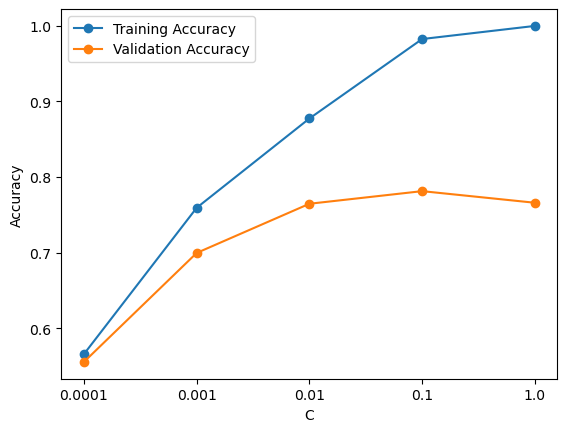

In [30]:
x_ticks = np.arange(len(df['C']))
plt.plot(x_ticks, df['training_accuracy'], 'o-', label='Training Accuracy')
plt.plot(x_ticks, df['val_accuracy'], 'o-', label='Validation Accuracy')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.xticks(x_ticks, df['C'])  # Imposta le etichette degli assi x con i valori di C
plt.legend()
# plt.savefig('C_parameter_n-grammi.pdf', dpi=300, bbox_inches='tight')
plt.show()

Il valore migliore per C è 0,1, che permette di ottenere un'accuracy media sui 5 diversi validation set (ottenuti tramite 5-Fold cross validation) dello 0.781.

In [31]:
best_SVC = LinearSVC(C=0.1) # creiamo il modello con il miglior valore di C
scores = cross_validate(best_SVC, X_train, y_train, scoring='f1', cv=splitter)
# cerchiamo anche il valore di F1 in validation
print("F1 score medio =", scores['test_score'].mean(), "con deviazione standard pari a", scores['test_score'].std())

F1 score medio = 0.7646706771577347 con deviazione standard pari a 0.01389351295900804


# Classificazione solo 'lemma'

In [32]:
lemma_features = select_type_of_features(train_features, ['lemma'])

In [33]:
get_num_features(lemma_features)

1591

In [34]:
lemma_vectorizer = DictVectorizer()
X_train_lemma = lemma_vectorizer.fit_transform(lemma_features)

In [35]:
lemma_scaler = MaxAbsScaler()
X_train_lemma = lemma_scaler.fit_transform(X_train_lemma)

## Model selection rispetto a C

In [36]:
df = pd.DataFrame(np.array([0.0001, 0.001, 0.01, 0.1, 1]), columns = ['C'])

In [37]:
for i, c in enumerate(df['C']): # proviamo diversi valori dell'iperparametro regolarizzatore C
    svc = LinearSVC(dual=False, C=c)
    svc.fit(X_train_lemma, y_train) # addestriamo il modello con il valore di C da valutare
    df.loc[i, 'training_accuracy'] = svc.score(X_train_lemma, y_train)
    scores = cross_validate(svc, X_train_lemma, y_train, scoring='accuracy', cv=splitter) # effettuiamo la Cross Validation
    df.loc[i, 'val_accuracy'] = scores['test_score'].mean()
    df.loc[i, 'val_accuracy_std'] = scores['test_score'].std()

In [38]:
df

,C,training_accuracy,val_accuracy,val_accuracy_std
0,0.0001,0.539333,0.539333,0.008273
1,0.0010,0.569333,0.549000,0.014283
2,0.0100,0.751000,0.676667,0.012019
3,0.1000,0.861333,0.721667,0.013292
4,1.0000,0.926333,0.720667,0.011035


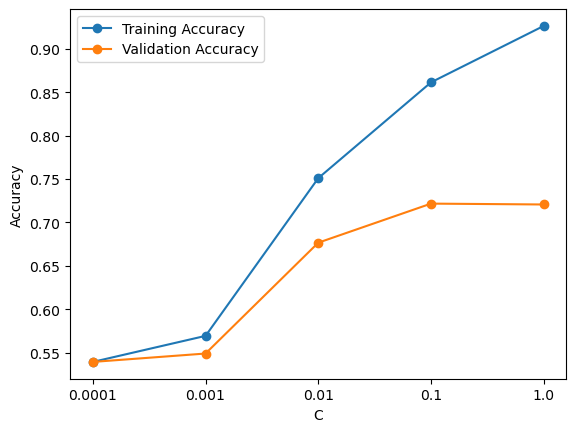

In [39]:
x_ticks = np.arange(len(df['C']))

plt.plot(x_ticks, df['training_accuracy'], 'o-', label='Training Accuracy')
plt.plot(x_ticks, df['val_accuracy'], 'o-', label='Validation Accuracy')

plt.xlabel('C')
plt.ylabel('Accuracy')

plt.xticks(x_ticks, df['C'])  # Imposta gli etichette degli assi x con i valori di C
plt.legend()
#plt.savefig('C_parameter.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
best_svc_lemma = LinearSVC(dual=False, C=0.1)
scores = cross_validate(best_svc_lemma, X_train_lemma, y_train, scoring='f1', cv=splitter)
scores['test_score'].mean()

0.6866981830153165

In [41]:
scores['test_score'].std()

0.012095814428823888

# Classificazione solo 'word'

In [42]:
word_features = select_type_of_features(train_features, ['word'])
word_vectorizer = DictVectorizer()
X_train_word = word_vectorizer.fit_transform(word_features)

In [43]:
get_num_features(word_features)

1509

In [44]:
word_scaler = MaxAbsScaler()
X_train_word = word_scaler.fit_transform(X_train_word)

## Model selection rispetto a C

In [45]:
df = pd.DataFrame(np.array([0.0001, 0.001, 0.01, 0.1, 1]), columns = ['C'])
splitter = KFold(n_splits=5, shuffle=True, random_state=42)
for i, c in enumerate(df['C']): # proviamo diversi valori dell'iperparametro regolarizzatore C
    svc = LinearSVC(C=c)
    svc.fit(X_train_word, y_train) # addestriamo il modello con il valore di C da valutare
    df.loc[i, 'training_accuracy'] = svc.score(X_train_word, y_train)
    scores = cross_validate(svc, X_train_word, y_train, scoring='accuracy', cv=splitter) # effettuiamo la Cross Validation
    df.loc[i, 'val_accuracy'] = scores['test_score'].mean()
    df.loc[i, 'val_accuracy_std'] = scores['test_score'].std()
df

,C,training_accuracy,val_accuracy,val_accuracy_std
0,0.0001,0.539333,0.539333,0.008273
1,0.0010,0.564000,0.548667,0.010873
2,0.0100,0.751333,0.682333,0.013928
3,0.1000,0.861667,0.732333,0.008273
4,1.0000,0.912333,0.724667,0.018481


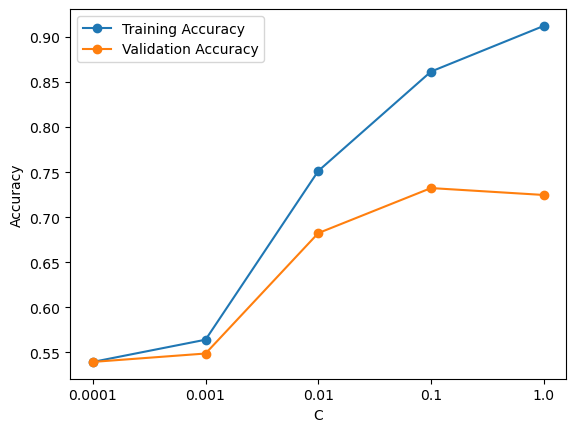

In [46]:
x_ticks = np.arange(len(df['C']))

plt.plot(x_ticks, df['training_accuracy'], 'o-', label='Training Accuracy')
plt.plot(x_ticks, df['val_accuracy'], 'o-', label='Validation Accuracy')

plt.xlabel('C')
plt.ylabel('Accuracy')

plt.xticks(x_ticks, df['C'])  # Imposta gli etichette degli assi x con i valori di C
plt.legend()
#plt.savefig('C_parameter_n-grammi.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
best_svc_word = LinearSVC(dual=False, C=0.1)
scores = cross_validate(best_svc_word, X_train_word, y_train, scoring='f1', cv=splitter)
scores['test_score'].mean()

0.6928050018472988

In [48]:
scores['test_score'].std()

0.0156455028820419

# Classificazione solo word e char

In [49]:
word_char_features = select_type_of_features(train_features, ['word', 'char'])
word_c_vectorizer = DictVectorizer()
X_train_word_char = word_c_vectorizer.fit_transform(word_char_features)

In [50]:
get_num_features(word_char_features)

4494

In [51]:
word_c_scaler = MaxAbsScaler()
X_train_word_char = word_c_scaler.fit_transform(X_train_word_char)

## Model selection rispetto a C

In [52]:
df = pd.DataFrame(np.array([0.0001, 0.001, 0.01, 0.1, 1]), columns = ['C'])
splitter = KFold(n_splits=5, shuffle=True, random_state=42)
for i, c in enumerate(df['C']): # proviamo diversi valori dell'iperparametro regolarizzatore C
    svc = LinearSVC(C=c)
    svc.fit(X_train_word_char, y_train) # addestriamo il modello con il valore di C da valutare
    df.loc[i, 'training_accuracy'] = svc.score(X_train_word_char, y_train)
    scores = cross_validate(svc, X_train_word_char, y_train, scoring='accuracy', cv=splitter) # effettuiamo la Cross Validation
    df.loc[i, 'val_accuracy'] = scores['test_score'].mean()
    df.loc[i, 'val_accuracy_std'] = scores['test_score'].std()
df

,C,training_accuracy,val_accuracy,val_accuracy_std
0,0.0001,0.552667,0.546667,0.012605
1,0.0010,0.735000,0.678000,0.015542
2,0.0100,0.858333,0.759000,0.015261
3,0.1000,0.963000,0.782667,0.015370
4,1.0000,0.999667,0.760667,0.011479


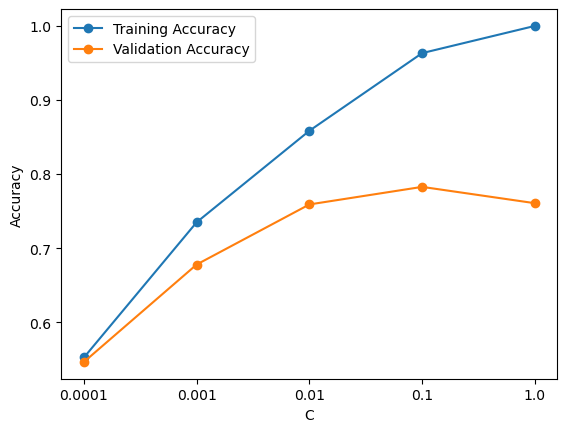

In [53]:
x_ticks = np.arange(len(df['C']))

plt.plot(x_ticks, df['training_accuracy'], 'o-', label='Training Accuracy')
plt.plot(x_ticks, df['val_accuracy'], 'o-', label='Validation Accuracy')

plt.xlabel('C')
plt.ylabel('Accuracy')

plt.xticks(x_ticks, df['C'])  # Imposta gli etichette degli assi x con i valori di C
plt.legend()
#plt.savefig('C_parameter.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [54]:
best_svc_word_char = LinearSVC(C=0.1)
scores = cross_validate(best_svc_word_char, X_train_word_char, y_train, scoring='f1', cv=splitter)
scores['test_score'].mean()

0.7673029520682106

In [55]:
scores['test_score'].std()

0.017652931736018562

## Valutazione sul test set

Poiché utilizzare n-grammi di parole e caratteri pare portare a una performance leggermente migliore, testiamo il modello con queste feature anche sul test set.

In [56]:
test_dataset = []
y_test = []

for file_path in test_files:
    doc_sentences = get_sentences_from_file(file_path)
    test_dataset.append(doc_sentences)
    y_test.append(int(file_path.split('-')[2]))

test_features = extract_features(test_dataset)
test_features = select_type_of_features(test_features, ['word', 'char'])

In [57]:
len(test_features)

1000

In [58]:
X_test = word_c_vectorizer.transform(test_features)
X_test = word_c_scaler.transform(X_test)

In [59]:
X_test

<1000x4494 sparse matrix of type '<class 'numpy.float64'>'
	with 80254 stored elements in Compressed Sparse Row format>

In [60]:
X_train_word_char.shape

(3000, 4494)

In [61]:
best_svc_word_char.fit(X_train_word_char, y_train)

LinearSVC(C=0.1)

In [62]:
y_test_pred = best_svc_word_char.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.56      0.59      0.57       323
           1       0.80      0.78      0.79       677

    accuracy                           0.72      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.72      0.72      0.72      1000



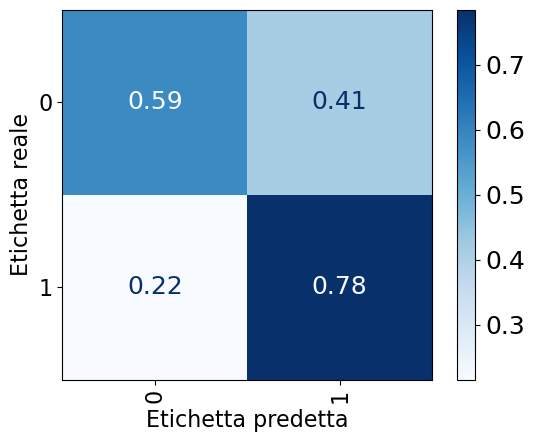

In [63]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, xticks_rotation='vertical', cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig('conf_matrix_SVC_n-grammi.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [64]:
accuracy_score(y_test_pred, y_test)

0.72

# Feature importance

In [65]:
coefs = best_svc_word_char.coef_
coefs.shape

(1, 4494)

In [66]:
features_names = word_c_vectorizer.get_feature_names_out(X_train_word_char).tolist()
len(features_names)

4494

In [67]:
feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, coefs[0])}

In [68]:
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

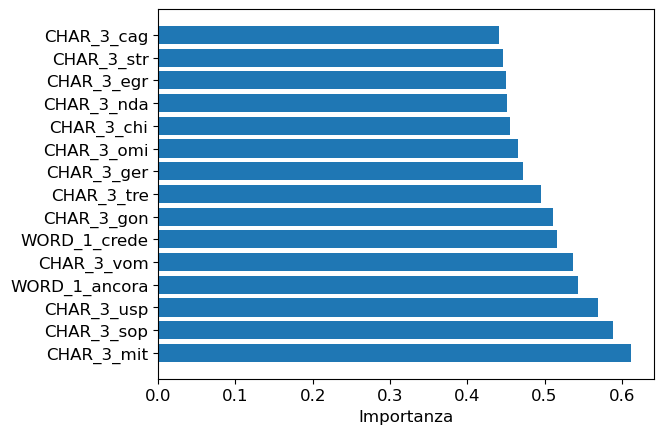

In [69]:
num_to_plot = 15
plt.rcParams.update({'font.size': 12})
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())[:num_to_plot])
plt.yticks(range(num_to_plot), list(sorted_feature_importances.keys())[:num_to_plot])
plt.xlabel('Importanza')
plt.savefig('feature_importanti_n-grammi.pdf', dpi=300, bbox_inches='tight')
plt.show()